## Import the dataset
[coursework doc](https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs342/coursework_cs342_2020-2021.pdf)
[iterative process](https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs342/iterativeprocess.pdf)

Dataset information:
1) sepal length in cm 
2) sepal width in cm
3) petal length in cm
4) petal width in cm


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math

#import the flower data
df = pd.read_csv("./iris.data", header=None)

#Convert the class names from strings to integers so they can be compared in the perceptron
df[4].replace('Iris-setosa',0,inplace=True)
df[4].replace('Iris-versicolor',1,inplace=True)
df[4].replace('Iris-virginica',2,inplace=True)

#Variables of the data which have just features and just labels
features = df.iloc[:,:-1].values.tolist()
labels = df.iloc[:,-1:].values.tolist()

#Gamma calculations for the grid search

df_gamma = (df-df.mean())
variances = []
for i in range(4): 
    #print("Variance of feature " + str(i) + ": " + str(df_gamma.describe()[i][2]**2))
    variances.append(df_gamma.describe()[i][2]**2)
variances = sorted(variances)

epsilon = 0.05
calculatedGammaMin = (1)/(2*(variances[3]+epsilon))
calculatedGammaMax = (1)/(2*(variances[0]-epsilon))

print(calculatedGammaMin)
print(calculatedGammaMax)

0.15806880795325862
3.62308268409637


## Method A
Convert the 4D data into 2D using PCA and visualise, based on SVD from lab 5

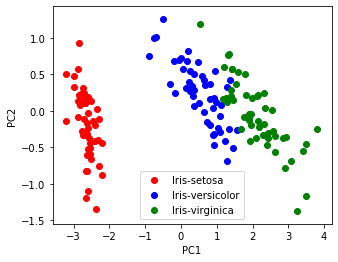

In [2]:
# Code from lab 5 for PCA using SVD
def pca_decomposition(dataset):
    data_centred = (dataset - dataset.mean())
    U, s, V = np.linalg.svd(data_centred, full_matrices=True)
    return U, s, V

x_features = df[df.columns[:-1]]
x_label = df[df.columns[-1]]


U, s, V = pca_decomposition(x_features)
projected_U = U[:, :2] #only take the first 2 components because we want 2D reduction
projected_U *= s[:2] #take the eigenvectors and multiply by the singular values to get the principal components


dimension_reduced_iris = pd.DataFrame(data = projected_U, columns = ['PC1', 'PC2'])
#add the labels back to the data so it can be used in the graph..
dimension_reduced_iris["label"] = x_label


plt.figure(figsize=(5, 4))
#setosa
setosa = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 0]
plt.scatter(setosa["PC1"], setosa["PC2"], c="r", marker="o")

#versicolor
versicolor = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 1]
plt.scatter(versicolor["PC1"], versicolor["PC2"], c="b", marker="o")

#virginica
virginica = dimension_reduced_iris.loc[dimension_reduced_iris['label'] == 2]
plt.scatter(virginica["PC1"], virginica["PC2"], c="g", marker="o")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Iris-setosa", "Iris-versicolor", "Iris-virginica"])

plt.show()


## Method B
Multi class perceptron on the 2d subspace. Make sure to encourage the largest predicted value to be the correct classification. Use the lab as a starting point.


### Hints
1) Define the class labels as numerical values, e.g., use 0, 1 and 2, for the three labels.
2) Determine how to update the weights of the linear classifier that provides the maximum predicted value and those of the
linear classifier associated with the correct class when the prediction is incorrect.
3) Recall adding a bias to the linear classifiers.
4) The algorithm may need to run for several iterations, as the data is not linearly separable. In each iteration, all training
samples should be used in random order. Train your

### Convert the dataset labels into numbers rather than text
0 = Iris-setosa
1 = Iris-versicolor
2 = Iris-virginica

In [3]:
#A multiclass perceptron class which is generalised for any number of classes and any type of data.
class MultiClassPerceptron():
    def __init__(self, data, classes, iterations):
        self.data = data
        self.classes = classes
        self.iterations = iterations
        
         
        #Create the weights for each classes with a bias term of 1 at the 0 index for each weight vector
        #Has the label included at this point and not the bias so it balanced out in size
        feature_count = len(self.data[0])
        self.weights = {}
        for i in self.classes:
            self.weights[i] = np.array([0.0 for i in range(feature_count)])
            
        #Add the bias (1) to each of the feature vectors for all training examples
        for idx, feature_vector in enumerate(self.data):
            self.data[idx] = [1.0] + self.data[idx]
        
    def train(self):
        #Run the training for the specified number of iterations
        for iteration in range(self.iterations):
            random.shuffle(self.data)
            
            for n in self.data:
                features = n[:-1]
                label = int(n[-1:][0])
                
                #current largest predicted value
                argmax = 0
                #current predicted class
                predicted_class = random.choice(self.classes)
                
                #classify the training examples for all classifiers (each class)
                for idx, c in enumerate(self.classes):
                    classification = np.dot(self.weights[c], features)
                    
                    if classification >= argmax:
                        argmax = classification
                        predicted_class = c
                        #print("Classification for classifier " + str(c) + " = " + str(classification) + " actual (" + str(label) + ")")
                
                #Refine the solution if the prediction is wrong
                if not (str(predicted_class) == str(label)):
                    #Add weight to the right class based on the features of current testing example
                    self.weights[str(label)] += np.array(features)
                    #Subtract weight to the one we predicted incorrectly
                    self.weights[str(predicted_class)] -= np.array(features)
                    #Restart on all the examples again (without shuffling again)
                    continue
    
    def predict(self, features):
        #add the bias
        features = [1] + features
        
        argmax = 0
        predicted_class = self.classes[0]
        
        #for each classifier run it on the example only returning the largest predicted value
        for c in self.classes:
            classification = np.dot(self.weights[c], features)
            if classification >= argmax:
                argmax = classification
                predicted_class = c
            
        return predicted_class
    
    def get_weights(self):
        return self.weights
    
    def get_data(self):
        return self.data
    
    def get_accuracy(self):
        inaccurate_predictions = 0
        for example in self.data:
            #remove the bias and the label, store the label to compare against after prediction
            label = int(example[-1])
            features = example[1:-1]
            predicted_class = self.predict(features)
            if str(predicted_class) != str(label):
                inaccurate_predictions += 1
        return inaccurate_predictions
        #return (len(self.data)-inaccurate_predictions)/len(self.data)
    

#Example usage of the multi-class perceptron

# accuracy_results = []
# mcp = MultiClassPerceptron(df.values.tolist(), ["0", "1", "2"], 50)
# mcp.train()

# print(mcp.get_accuracy())
# print(mcp.get_weights())


### 2D Projected multi-class perceptron
Using 2d feature vectors after applying pca to the original data and projecting the data points

[9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28, 9.28]


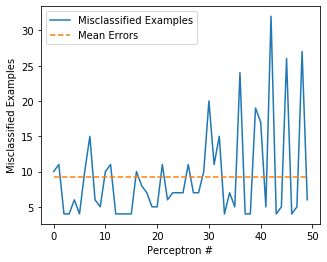

In [4]:
#Convert the projected data into a standard python list (used in the mutli-class perceptron)
#Projected_U is from before which is the 2d projected iris data
projected_list = projected_U.tolist()

for idx, label in enumerate(labels):
    #Add the labels back to the datapoints so the perceptron can use them to determine if it has predicted accurately
    projected_list[idx].append(label[0])


    
#Train 50 multi-class perceptrons for this dataset because the random shuffling and max iterations causes varying model error rates
accuracy_results = []

for i in range(50):
    twod_mcp = MultiClassPerceptron(projected_list, ["0", "1", "2"], 50)
    twod_mcp.train()

    accuracy_results.append(twod_mcp.get_accuracy())


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

ax.plot([i for i in range(50)], accuracy_results, label="Misclassified Examples")

average_errors = [np.mean(accuracy_results)]*len(accuracy_results)

ax.plot([i for i in range(50)], average_errors, label="Mean Errors", linestyle="--")

print(average_errors)
ax.legend(loc="upper left")
plt.xlabel("Perceptron #")
plt.ylabel("Misclassified Examples")
plt.show()



### All features classified
Using the 4d feature vectors (without pca) with the multi-class perceptron

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]


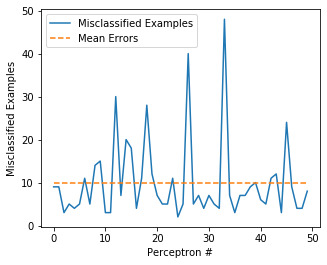

In [5]:
#Train 50 multi-class perceptrons for this dataset because the random shuffling and max iterations causes varying model error rates

accuracy_results = []

for i in range(50):
    fourd_mcp = MultiClassPerceptron(df.values.tolist(), ["0", "1", "2"], 50)
    fourd_mcp.train()

    accuracy_results.append(fourd_mcp.get_accuracy())


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

ax.plot([i for i in range(50)], accuracy_results, label="Misclassified Examples")

average_errors = [np.mean(accuracy_results)]*len(accuracy_results)

ax.plot([i for i in range(50)], average_errors, label="Mean Errors", linestyle="--")

print(average_errors)
ax.legend(loc="upper left")
plt.xlabel("Perceptron #")
plt.ylabel("Misclassified Examples")
plt.show()



### 4D Projected multi-class perceptron
Using 4d feature vectors by performing pca and then projected the data into 4d (top 4 principal components)

[5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02, 5.02]


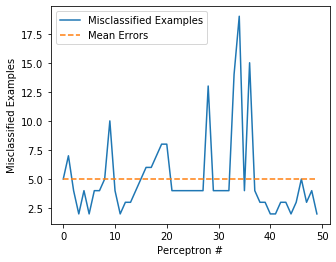

In [7]:
#Train 50 multi-class perceptrons for this dataset because the random shuffling and max iterations causes varying model error rates

U, s, V = pca_decomposition(x_features)

#Using PCA with all components to project the data into 4d
projected_X_4d = U[:, :4] 
projected_X_4d *= s[:4]

projected_list = projected_X_4d.tolist()
for idx, label in enumerate(labels):
    #Add the labels back to the datapoints so the perceptron can use them to determine if it has predicted accurately
    projected_list[idx].append(label[0])

accuracy_results = []

for i in range(50):
    fourd_mcp = MultiClassPerceptron(projected_list, ["0", "1", "2"], 50)
    fourd_mcp.train()

    accuracy_results.append(fourd_mcp.get_accuracy())


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

ax.plot([i for i in range(50)], accuracy_results, label="Misclassified Examples")

average_errors = [np.mean(accuracy_results)]*len(accuracy_results)

ax.plot([i for i in range(50)], average_errors, label="Mean Errors", linestyle="--")

print(average_errors)
ax.legend(loc="upper left")
plt.xlabel("Perceptron #")
plt.ylabel("Misclassified Examples")
plt.show()



# Kernel Method
Projecting the data onto a higher dimensional subspace so that, hopefully, the data becomes seperable

In [8]:
#L2 Norm squared, used in the kernel matrix generation
def l2Squared(xi, xj):
    return np.linalg.norm(np.array(xi) - np.array(xj), 2) ** 2

#Creating the kernel matrix, it is the dot product between all pairs of data in the dataset
    
#Computes the kernel matrix K (nxn matrix where n = number of training examples)
def computeKernelMatrix(data, gamma):
    K = []
    for idx, i in enumerate(data):
        K.append([])
        for idxTwo, j in enumerate(data):
             #K[idx].append(np.dot(i, j))
                rbfKernel = np.exp(-gamma * l2Squared(i, j)) 
                K[idx].append(rbfKernel)
            
    return K

#A nxn matrix of values being 1/n used to normalise the kernel matrix so kernel pca can be used
def computeNormalisedKernelMatrix(K):
    #Need to generate the A matrix which is an nxn matrix with all values set to 1/n (n being training sample size)
    A = []
    n = len(np.array(K).flatten())
    for i in range(int(math.sqrt(n))):
        A.append([])
        for j in range(int(math.sqrt(n))):
            A[i].append(1/n)
            
    #Now use the formula ~K = K-AK-KA+(AK)A - formula from coursework document
    normalisedK = K-np.dot(A, K) - np.dot(K, A) + np.dot((np.dot(A, K)), A)
    return normalisedK

#Kernel PCA, similar to the normal PCA, returns the max number of principal components projected   
def kernelPCA(normalisedK, components):
        #dont need to center the data here, it is already done by figuring out the normalised K
        U, s, V = np.linalg.svd(normalisedK, full_matrices=True)
        pcs = U[:, :components]
        pcs *= s[:components]
        return pcs
    
#class based implementation of a grid search for varying numbers of top principal components and gamma ranges
class GridSearch():
    def __init__(self, data, pc_min, pc_max, gammaMin, gammaMax):
        self.data = data
        self.pc_min = pc_min
        self.pc_max = pc_max
        self.gammaMin = gammaMin
        self.gammaMax = gammaMax
    
    #Produce a dictionary of keys (the hyper parameters) and accuracy results which can be used to determine the best parameters
    def calculateBestParameters(self):
        #for all the principal components
        scoresForParameters = {}
        
        for pc_components in range(self.pc_min, self.pc_max+1):
            #for all the possible gamma values
            for gamma in np.arange(self.gammaMin, self.gammaMax, 0.10):
                gamma = round(gamma, 2)
                acc = self.getAccuracyForParameters(pc_components, gamma)
                scoresForParameters[(pc_components, gamma)] = round(acc, 3)
                
        return scoresForParameters
     
    #Get the accuracy of a model with the given top principal components and gamma values
    def getAccuracyForParameters(self, pcs, gamma):
        #Debug text to ensure the code is still running (because it can take a long time)
        #print("-----[ pcs=" + str(pcs) + "  gamma=" + str(gamma) + " ]-----")
        K = computeKernelMatrix(self.data, gamma)
        NormalisedK = computeNormalisedKernelMatrix(K)

        #Apply kernel decompositon
        projected_kpca = kernelPCA(NormalisedK, pcs)
        
        #Dynamic column count so create the titles
        columns = []
        for i in range(pcs):
            columns.append("PC" + str(i+1))
        
        #Convert to dataframe and add back the labels
        kpca = pd.DataFrame(data = projected_kpca, columns = columns)
        kpca["label"] = x_label
        
        #Train the MCP
        gs_mcp = MultiClassPerceptron(kpca.values.tolist(), ["0", "1", "2"], 50)
        gs_mcp.train()
        return gs_mcp.get_accuracy()
    
    def get_pc_min(self):
        return self.pc_min

    def get_pc_max(self):
        return self.pc_max
    
    def get_gamma_min(self):
        return self.gammaMin
    
    def get_gamma_max(self):
        return self.gammaMax


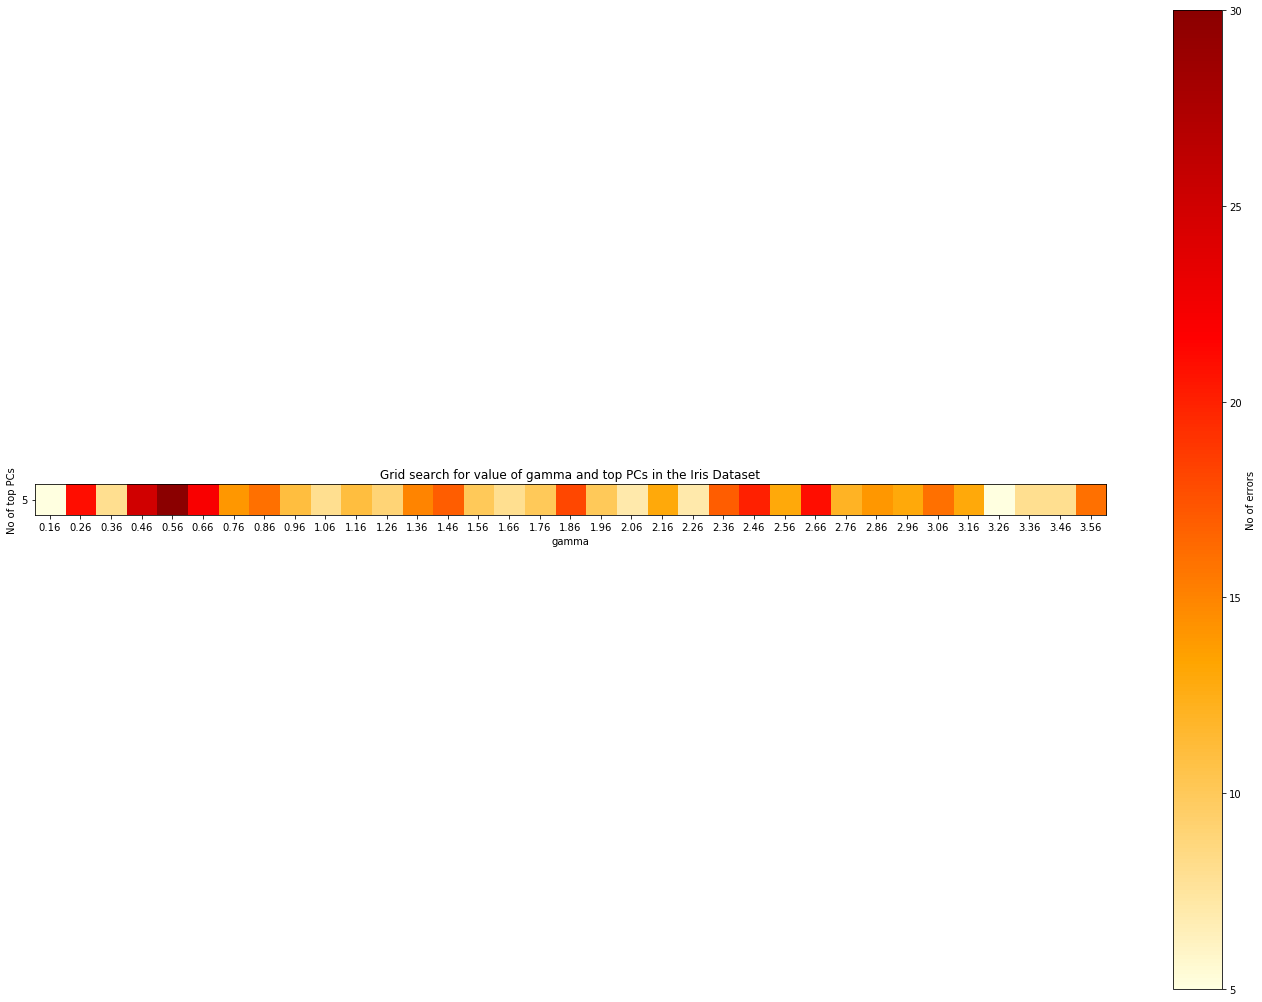

In [10]:
#Create the heatmap / matrix for the results of the grid search
gs = GridSearch(features, 5, 150, calculatedGammaMin, calculatedGammaMax)
gs_results = gs.calculateBestParameters()

#Convert the dictionary of results to a nested list of error values for the heatmap
len_for_nested_list = len(np.arange(gs.get_gamma_min(), gs.get_gamma_max(), 0.10))
current_nested_idx = 0
final_results = [[]]
for idx, tup in enumerate(gs_results.items()):
    if idx % len_for_nested_list == 0 and idx != 0:
        final_results.append(list())
        current_nested_idx += 1
    final_results[current_nested_idx].append(tup[1])

final_results.reverse()
p_components = [str(i) for i in range(gs.get_pc_min(), gs.get_pc_max()+1)]
p_components.reverse()
gamma = [round(gamma, 2) for gamma in np.arange(gs.get_gamma_min(), gs.get_gamma_max(), 0.10)]

import matplotlib
import matplotlib.pyplot as plt

#Custom colour map for yellow to red error counts
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightyellow","orange", "red", "darkred"])
        
fig, ax = plt.subplots(figsize=(24, 18))
im = ax.imshow(np.array(final_results), cmap=cmap)

#Text in the centre of the heatmap cells for debugging
# for i in range(len(p_components)):
#     for j in range(len(gamma)):
#         text = ax.text(j, i, final_results[i][j], ha="center", va="center", color="b")

ax.set_xticks(np.arange(len(gamma)))
ax.set_yticks(np.arange(len(p_components)))

ax.set_xticklabels(gamma)
ax.set_yticklabels(p_components)

fig.colorbar(im,ax=ax, label="No of errors")

plt.title("Grid search for value of gamma and top PCs in the Iris Dataset")
plt.xlabel("gamma")
plt.ylabel("No of top PCs")
plt.show()
